In [4]:
import os
import cv2 #OpenCV
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import shutil

In [5]:
xray_directory = 'data_to_tf'

In [6]:
os.listdir(xray_directory)

['cancer', 'normal']

In [7]:
# Instanciando objeto de ImageDataGenerator para acessar as imagens e aplicando rescale para normalizar os valores dos pixels

image_generator = ImageDataGenerator(rescale=1./255)

In [12]:
# Buscando as imagens de treino no diretório

# batch_size = quantidade de imagens por batch,
# directory = diretório das imagens,
# shuffle = True para embaralhar as imagens,
# target_size = definição do tamanho das imagens,
# class_mode = 'categorical' para classificação multiclasse,
# subset = 'training' indicando que as imagens são de treino

train_generator = image_generator.flow_from_directory(batch_size = 40, directory=xray_directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 3677 images belonging to 2 classes.


In [13]:
train_images, train_labels = next(train_generator)

In [14]:
# 40 - quantidade de imagens por batch
# 256 - altura das imagens
# 256 - largura das imagens
# 3 - quantidade de canais de cores (RGB)

train_images.shape

(40, 256, 256, 3)

In [15]:
train_labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [20]:
# cancer - 1 0
# normal - 0 1
labels_names = {0: 'cancer', 1: 'normal'}

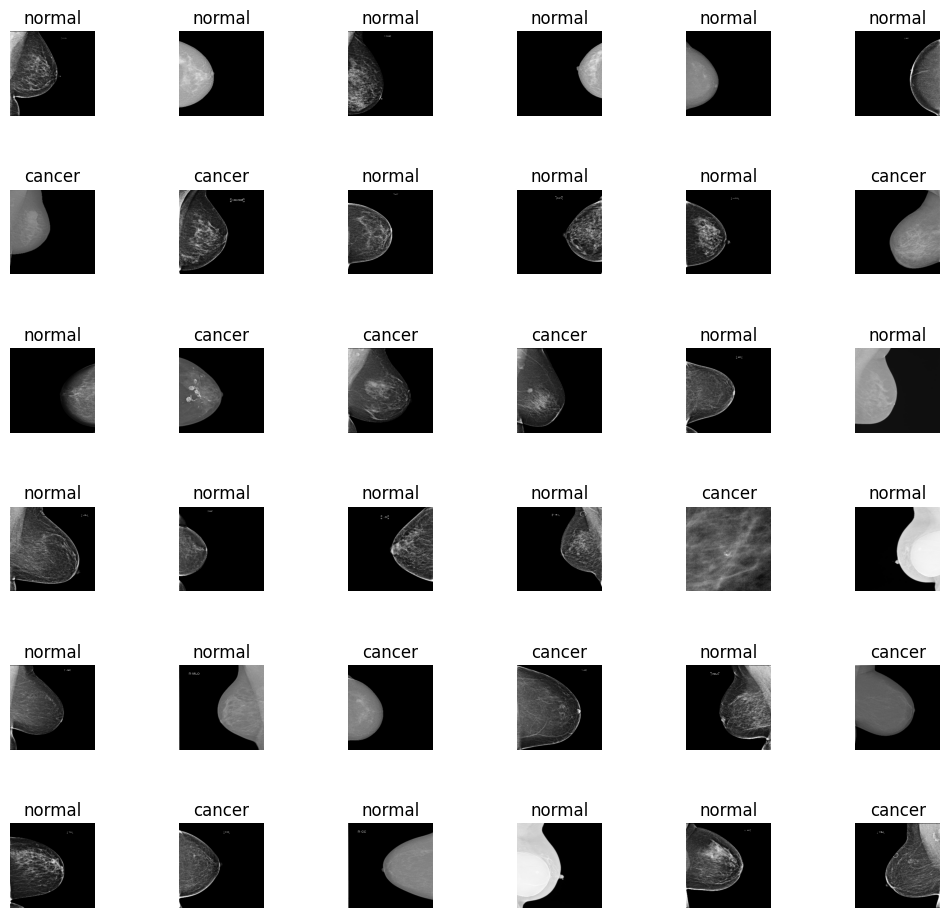

In [21]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
axes = axes.ravel()
for i in np.arange(0, 36):
  axes[i].imshow(train_images[i])
  axes[i].set_title(labels_names[np.argmax(train_labels[i])])
  axes[i].axis('off')
plt.subplots_adjust(wspace=1.0)

In [22]:
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_tensor = Input(shape=(256,256,3)))

In [23]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [24]:
len(base_model.layers)

175

In [25]:
# Congelando as últimas camadas do modelo. 
# Permite fazer um treinamento mais rápido, mas isso pode ter um impacto no desempenho do algoritmo.
# Avaliar a acurácia do modelo com as camadas congeladas e sem as camadas congeladas.

# for layer in base_model.layers[:-10]:
#     layer.trainable = False

In [32]:
# A variavel head_model é a parte do modelo que será treinada e esta ligada ao modelo base.
# AveragePooling2D - Camada de pooling que calcula a média dos valores dos pixels.
# Flatten - Transforma a matriz de pixels em um vetor.
# Dense - Camada densa de 256 neurônios.
# Dropout - Regularização para evitar overfitting.
# Dense - Camada densa de 256 neurônios.
# Dropout - Regularização para evitar overfitting.
# Dense - Camada densa de 4 neurônios com função de ativação softmax.


head_model = base_model.output
head_model = AveragePooling2D(pool_size=(4, 4))(head_model)
head_model = Flatten()(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(2, activation = 'softmax')(head_model)

In [33]:
# Criando o modelo final

# inputs = camada de entrada do modelo
# outputs = camada de saída do modelo

model = Model(inputs = base_model.input, outputs = head_model)

In [34]:
# Compilando o modelo

# categorical_crossentropy - Função de perda para classificação multiclasse
# RMSprop - Otimizador
# learning_rate - Taxa de aprendizado
# metrics - Métrica de avaliação do modelo

model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate = 1e-4),
              metrics = ['accuracy'])

In [35]:
# Salvando o modelo com a melhor acurácia

checkpointer = ModelCheckpoint(filepath='best-21-100-2024.keras')

In [36]:
# Redefunindo o gerador de imagens para o treinamento, pois o anterior foi utilizado para visualização das imagens.

train_generator = image_generator.flow_from_directory(batch_size = 16, directory=xray_directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 3677 images belonging to 2 classes.


In [37]:
# Treinando o modelo

# train_generator - gerador de imagens de treino
# epochs - quantidade de épocas
# callbacks - lista de callbacks

history = model.fit(train_generator, epochs = 30, callbacks=[checkpointer])

Epoch 1/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 563s 2s/step - accuracy: 0.5550 - loss: 0.7165
Epoch 2/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 542s 2s/step - accuracy: 0.5856 - loss: 0.6606
Epoch 3/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 546s 2s/step - accuracy: 0.6481 - loss: 0.6091
Epoch 4/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 540s 2s/step - accuracy: 0.7014 - loss: 0.5578
Epoch 5/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.7539 - loss: 0.5038
Epoch 6/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.8039 - loss: 0.4248
Epoch 7/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 560s 2s/step - accuracy: 0.8725 - loss: 0.3009
Epoch 8/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 565s 2s/step - accuracy: 0.9224 - loss: 0.2256
Epoch 9/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 561s 2s/step - accuracy: 0.9488 - loss: 0.1550
Epoch 10/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.9571 - loss: 0.1318
Epoch 11/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 536s 2s/step - accuracy: 0.9647 - loss: 0.0998
Epoch 12/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 

In [38]:
history.history.keys()

dict_keys(['accuracy', 'loss'])

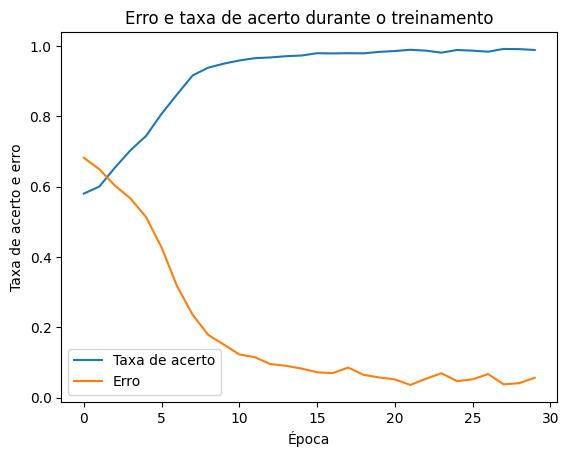

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Erro e taxa de acerto durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Taxa de acerto e erro')
plt.legend(['Taxa de acerto', 'Erro']);

In [52]:
test_directory = r'data_to_tf\test'

In [60]:
os.listdir(test_directory)

['cancer', 'normal']

In [54]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(batch_size = 20, directory = test_directory,
                                              shuffle = True, target_size = (256, 256),
                                              class_mode = 'categorical')

Found 800 images belonging to 2 classes.


In [55]:
evaluate = model.evaluate(test_generator)

40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 796ms/step - accuracy: 0.9887 - loss: 0.0320


In [56]:
evaluate

[0.020353352651000023, 0.9925000071525574]

In [64]:
label_map = {'cancer': 0, 'normal': 1}

In [65]:
prediction = []
original = []
image = []

# Loop sobre as pastas 'cancer' e 'normal'
for label_name in os.listdir(test_directory):
    label = label_map[label_name]  # Mapeando para 0 ou 1
    folder_path = os.path.join(test_directory, label_name)

    # Loop sobre cada imagem na pasta
    for item in os.listdir(folder_path):
        img_path = os.path.join(folder_path, item)

        # Lendo e processando a imagem
        img = cv2.imread(img_path)
        img = cv2.resize(img, (256, 256))
        image.append(img)  # Armazenando a imagem original para referência

        # Normalizando e ajustando o formato para o modelo
        img = img / 255.0
        img = img.reshape(1, 256, 256, 3)

        # Fazendo a previsão
        predict = model.predict(img)
        predict = np.argmax(predict)  # Obtendo a classe prevista

        # Armazenando os resultados
        prediction.append(predict)
        original.append(label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━

In [66]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [68]:
accuracy_score(original, prediction)

0.98125

In [67]:
labels_names

{0: 'cancer', 1: 'normal'}

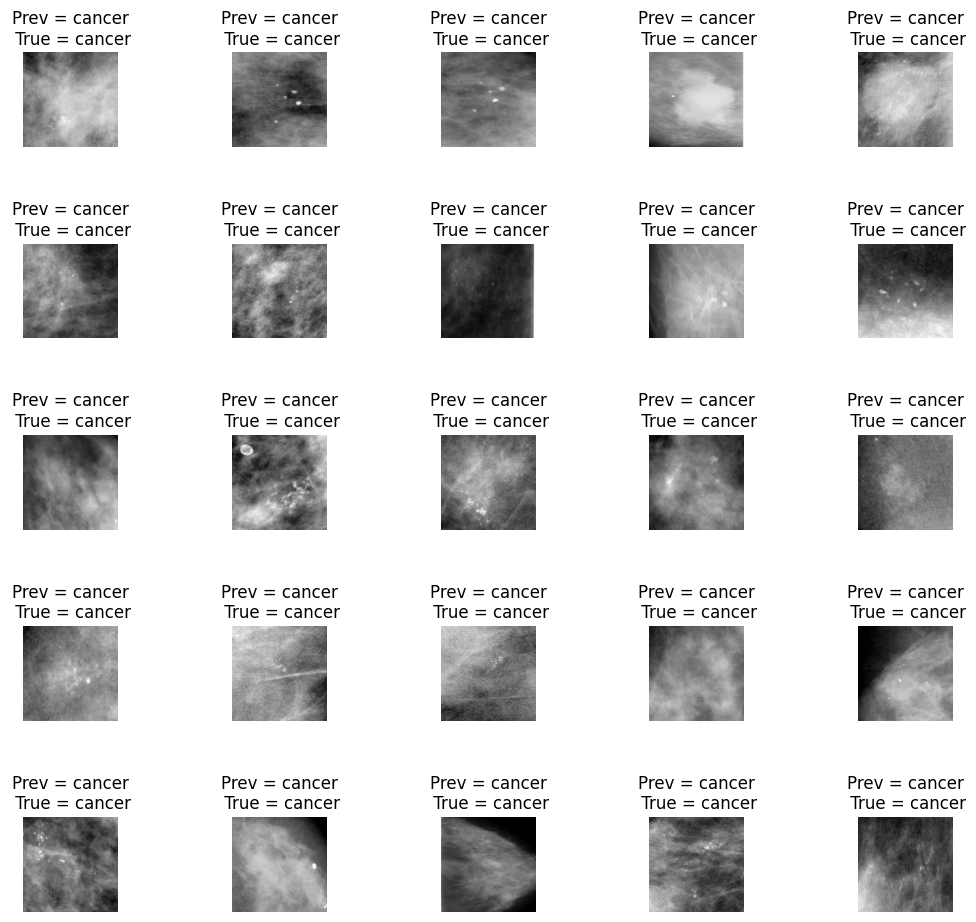

In [69]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()
for i in np.arange(0, 25):
  axes[i].imshow(image[i])
  axes[i].set_title(f'Prev = {labels_names[prediction[i]]}\n True = {labels_names[original[i]]}')
  axes[i].axis('off')
plt.subplots_adjust(wspace = 1.2)

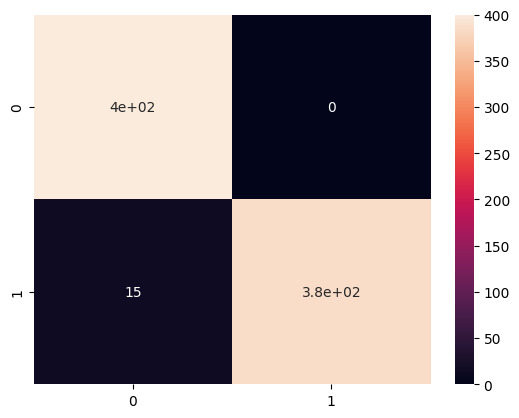

In [70]:
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot=True);

In [71]:
print(classification_report(original, prediction))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       400
           1       1.00      0.96      0.98       400

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800

